In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

zip_file_path = '/content/drive/MyDrive/pnuemonia_dataset.zip'
os.chdir(os.path.dirname(zip_file_path))


In [3]:
import zipfile

# Extract the zip file
with zipfile.ZipFile(os.path.basename(zip_file_path), 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files')

os.chdir('/content/extracted_files')


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/extracted_files/chest_xray/train'
test_dir = '/content/extracted_files/chest_xray/test'
val_dir = '/content/extracted_files/chest_xray/val'

## 1. Descriptive analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2


Train Dataset Distribution:
    Category  Count
0  PNEUMONIA   3875
1     NORMAL   1341

Test Dataset Distribution:
    Category  Count
0  PNEUMONIA    390
1     NORMAL    234


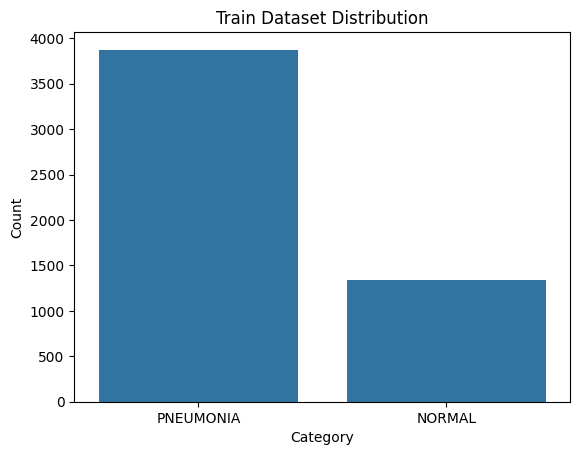

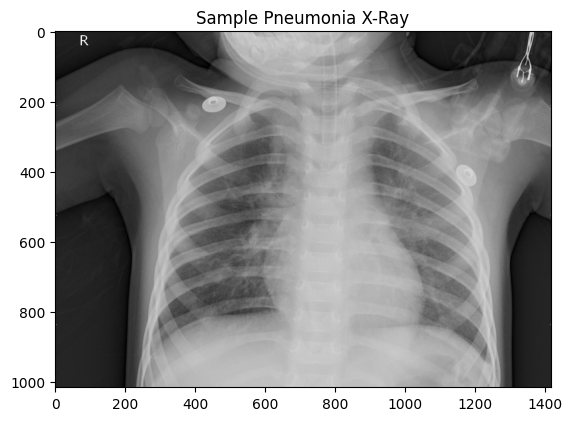

In [6]:
categories = ['PNEUMONIA', 'NORMAL']


train_data = [(category, len(os.listdir(os.path.join(train_dir, category)))) for category in categories]
test_data = [(category, len(os.listdir(os.path.join(test_dir, category)))) for category in categories]

train_df = pd.DataFrame(train_data, columns=['Category', 'Count'])
test_df = pd.DataFrame(test_data, columns=['Category', 'Count'])

print("Train Dataset Distribution:")
print(train_df)

print("\nTest Dataset Distribution:")
print(test_df)

# Visualization
sns.barplot(x='Category', y='Count', data=train_df)
plt.title("Train Dataset Distribution")
plt.show()

sample_img = cv2.imread(os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0]))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Sample Pneumonia X-Ray")
plt.show()

## 2. Diagnostic analysis

In [ ]:
# Analyze image sizes
image_sizes = [cv2.imread(os.path.join(train_dir, category, filename)).shape[:2]
               for category in categories for filename in os.listdir(os.path.join(train_dir, category))]
image_sizes_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])

sns.jointplot(x='Width', y='Height', data=image_sizes_df, kind='hex')
plt.suptitle("Image Size Distribution")
plt.show()

# Analyze pixel intensity distributions
sample_pneumonia_img = cv2.imread(os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0]), cv2.IMREAD_GRAYSCALE)
sample_normal_img = cv2.imread(os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0]), cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(sample_pneumonia_img.ravel(), bins=256, color='red')
axs[0].set_title("Pneumonia Image Pixel Intensity Distribution")
axs[1].hist(sample_normal_img.ravel(), bins=256, color='blue')
axs[1].set_title("Normal Image Pixel Intensity Distribution")
plt.show()


In [ ]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        color_mode = 'rgb',
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=64,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='binary')


val_generator = test_datagen.flow_from_directory(
        val_dir,
        color_mode = 'rgb',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
test_dir,
color_mode = 'rgb',
target_size=(224, 224),
batch_size=64,
class_mode='binary')

In [ ]:
from tensorflow.keras import backend as K

def recall_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_custom(y_true, y_pred):
    precision = precision_custom(y_true, y_pred)
    recall = recall_custom(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import tensorflow as tf
base_model_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in base_model_vgg16.layers:
    layer.trainable = False

model_vgg16=tf.keras.models.Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.7),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_custom])
model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                         

In [7]:
history_vgg16 = model_vgg16.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15
82/82 [==============================] - 99s 1s/step - loss: 1.1809 - accuracy: 0.7883 - f1_custom: 0.8513 - val_loss: 0.2840 - val_accuracy: 0.8750 - val_f1_custom: 0.8571
Epoch 2/15
82/82 [==============================] - 93s 1s/step - loss: 0.2917 - accuracy: 0.8737 - f1_custom: 0.9148 - val_loss: 0.4725 - val_accuracy: 0.7500 - val_f1_custom: 0.8000
Epoch 3/15
82/82 [==============================] - 92s 1s/step - loss: 0.2732 - accuracy: 0.8788 - f1_custom: 0.9181 - val_loss: 0.6299 - val_accuracy: 0.6875 - val_f1_custom: 0.7619
Epoch 4/15
82/82 [==============================] - 92s 1s/step - loss: 0.2642 - accuracy: 0.8875 - f1_custom: 0.9243 - val_loss: 0.4067 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 5/15
82/82 [==============================] - 91s 1s/step - loss: 0.2592 - accuracy: 0.8880 - f1_custom: 0.9238 - val_loss: 0.4231 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 6/15
82/82 [==============================] - 92s 1s/step - loss: 0.2540 -

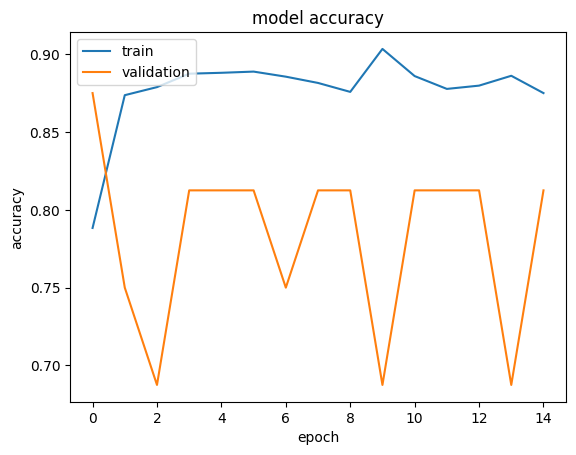

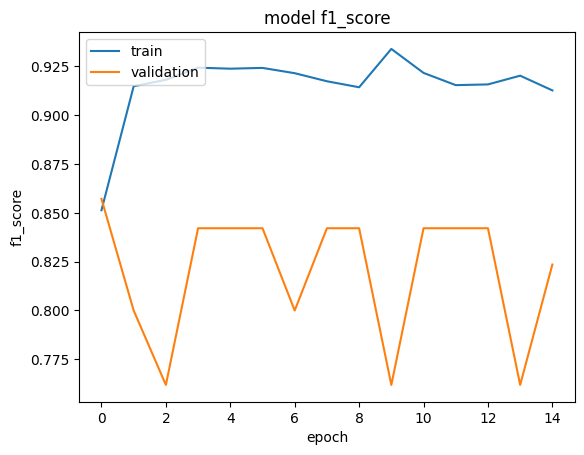

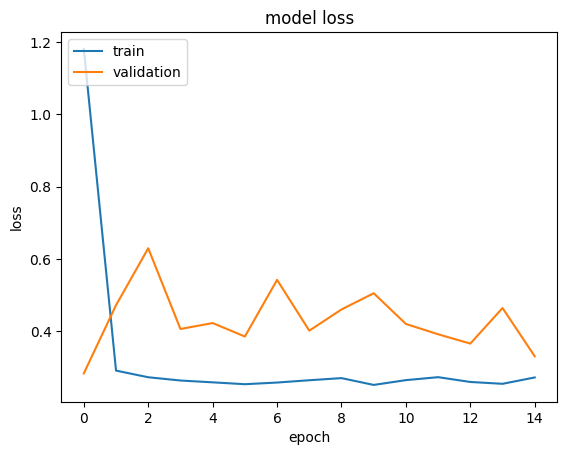

In [8]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for f1_score
plt.plot(history_vgg16.history['f1_custom'])
plt.plot(history_vgg16.history['val_f1_custom'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
model_vgg16.evaluate(test_generator)

10/10 [==============================] - 7s 663ms/step - loss: 0.2786 - accuracy: 0.9215 - f1_custom: 0.9356


[0.27860501408576965, 0.9214743375778198, 0.9355837106704712]

## Custom Model

In [10]:
train_datagen_for_custom = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True)

# Note that the validation data should not be augmented!
test_datagen_for_custom = ImageDataGenerator(rescale=1./255)

train_generator_for_custom = test_datagen_for_custom.flow_from_directory(
        # This is the target directory
        train_dir,
        color_mode = 'grayscale',
        # All images will be resized to 150x150
        target_size=(300, 300),
        batch_size=64,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='binary')

val_generator_for_custom = test_datagen_for_custom.flow_from_directory(
        val_dir,
        color_mode = 'grayscale',
        target_size=(300, 300),
        batch_size=64,
        class_mode='binary')

test_generator_for_custom = test_datagen_for_custom.flow_from_directory(
        test_dir,
        color_mode = 'grayscale',
        target_size=(300, 300),
        batch_size=64,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
import tensorflow as tf

# Define ReLU6 activation
relu6 = tf.keras.layers.ReLU(6.)

def _conv_block(inputs, filters, kernel, strides):
    x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    return relu6(x)


def _bottleneck(inputs, filters, kernel, t, s, r=False):
    tchannel = inputs.shape[-1] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = relu6(x)

    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x


def MobileNetV2(input_shape, k, plot_model=False):
    inputs = tf.keras.layers.Input(shape=input_shape, name='input')
    x = _conv_block(inputs, 64, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 64, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=1)
    x = _inverted_residual_block(x, 128, (3, 3), t=6, strides=2, n=1)
    x = _inverted_residual_block(x, 128, (3, 3), t=6, strides=2, n=1)

    x = _inverted_residual_block(x, 256, (3, 3), t=6, strides=2, n=1)
    x = _inverted_residual_block(x, 256, (3, 3), t=6, strides=1, n=1)

    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='final_activation')(x)
    model = tf.keras.models.Model(inputs, x)
    model.summary()
    if plot_model:
        tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [30]:
custom_model_mobilenet = MobileNetV2((300, 300, 1), 1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 300, 300, 1)]        0         []                            
                                                                                                  
 conv2d_99 (Conv2D)          (None, 150, 150, 64)         640       ['input[0][0]']               
                                                                                                  
 batch_normalization_145 (B  (None, 150, 150, 64)         256       ['conv2d_99[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 re_lu_75 (ReLU)             multiple                     0         ['batch_normalization_14

In [31]:
custom_model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_custom])
history_custom_mobilenet = custom_model_mobilenet.fit(train_generator_for_custom, validation_data=val_generator_for_custom, epochs=30)

Epoch 1/30
82/82 [==============================] - 41s 372ms/step - loss: 0.5195 - accuracy: 0.8773 - f1_custom: 0.9208 - val_loss: 16.5823 - val_accuracy: 0.5000 - val_f1_custom: 0.6667
Epoch 2/30
82/82 [==============================] - 30s 369ms/step - loss: 0.0689 - accuracy: 0.9730 - f1_custom: 0.9816 - val_loss: 22.4764 - val_accuracy: 0.5000 - val_f1_custom: 0.6667
Epoch 3/30
82/82 [==============================] - 30s 367ms/step - loss: 0.0204 - accuracy: 0.9942 - f1_custom: 0.9961 - val_loss: 27.6513 - val_accuracy: 0.5000 - val_f1_custom: 0.6667
Epoch 4/30
82/82 [==============================] - 30s 369ms/step - loss: 0.0182 - accuracy: 0.9933 - f1_custom: 0.9954 - val_loss: 26.3143 - val_accuracy: 0.5000 - val_f1_custom: 0.6667
Epoch 5/30
82/82 [==============================] - 30s 363ms/step - loss: 0.0399 - accuracy: 0.9866 - f1_custom: 0.9907 - val_loss: 1.1740 - val_accuracy: 0.5000 - val_f1_custom: 0.0000e+00
Epoch 6/30
82/82 [==============================] - 31s 3

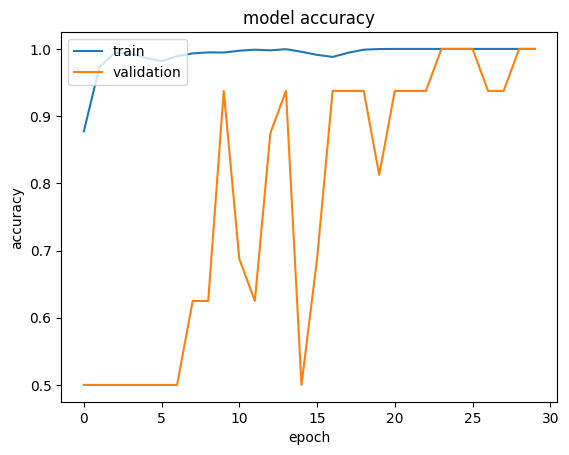

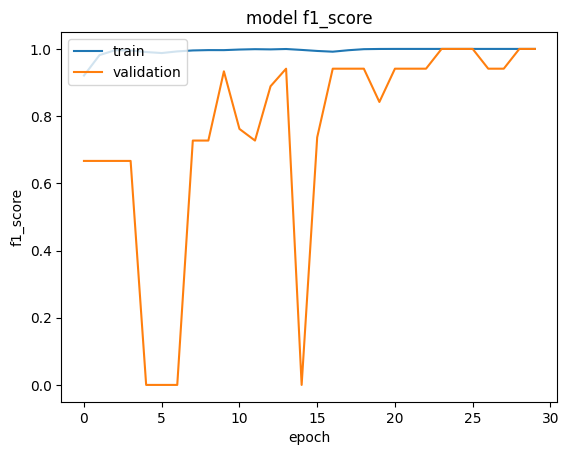

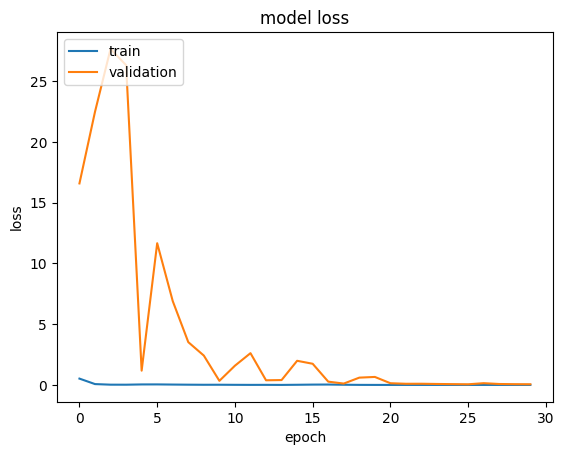

In [32]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_custom_mobilenet.history['accuracy'])
plt.plot(history_custom_mobilenet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for f1_score
plt.plot(history_custom_mobilenet.history['f1_custom'])
plt.plot(history_custom_mobilenet.history['val_f1_custom'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_custom_mobilenet.history['loss'])
plt.plot(history_custom_mobilenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
custom_model_mobilenet.evaluate(test_generator_for_custom)

10/10 [==============================] - 3s 281ms/step - loss: 3.4488 - accuracy: 0.7484 - f1_custom: 0.8272


[3.4488325119018555, 0.7483974099159241, 0.8272377252578735]